In [104]:
import pandas as pd
import numpy as np
import xgboost
import pickle
import sqlite3
from datetime import datetime
import os
import shap
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', 1000)

In [73]:
# Load the XGBoost model from a pickle file
with open('model/hyperopt_model_Win_20230401_131327.pkl', 'rb') as f:
    xgb_model_win = pickle.load(f)
    explainer_win = shap.TreeExplainer(xgb_model_win)
    expected_value_win = explainer_win.expected_value

with open('model/hyperopt_model_Draw_20230401_131434.pkl', 'rb') as f:
    xgb_model_draw = pickle.load(f)
    explainer_draw = shap.TreeExplainer(xgb_model_draw)
    expected_value_draw = explainer_draw.expected_value

In [223]:
def make_prediction(
    home_team,
    away_team,
    match_date,
    bet365_home_win,
    bet365_away_win,
    bet365_draw,
    xgb_model_win=xgb_model_win,
    xgb_model_draw=xgb_model_draw,
    explainer_win=explainer_win,
    expected_value_win=expected_value_win,
    explainer_draw=explainer_draw,
    expected_value_draw=expected_value_draw,
):
    """Make prediction"""
    data_path = os.path.join(os.getcwd(), "data")
    data_files = os.listdir(data_path)

    ### Merge fbref files into single dataset
    fbref_teams_df = pd.read_csv(
        "data/fbref_team_season_stats_standard.csv", sep=";", index_col=0
    )[["league", "season", "team"]].drop_duplicates()

    for f in [_ for _ in data_files if _.startswith("fbref")]:
        fbref_df = pd.read_csv(os.path.join(data_path, f), sep=";", index_col=0)
        try:
            fbref_df = fbref_df.drop(columns=["url", "#_Pl"])
        except:
            pass
        duplicated_cols = [
            col
            for col in fbref_df.columns
            if col in fbref_teams_df.columns and col not in ["team", "league", "season"]
        ]

        if len(duplicated_cols) > 0:
            fbref_df = fbref_df.drop(columns=duplicated_cols)

        fbref_teams_df = fbref_teams_df.merge(
            fbref_df, how="inner", on=["team", "league", "season"]
        )

    # Create match data dfs
    home_team_match_data = pd.DataFrame(
        {
            "match_id": [1],
            "Match_Date": [match_date],
            "Home_Team": [home_team],
            "Bet365_home_win_odds": [bet365_home_win],
            "Bet365_draw_odds": [bet365_draw],
            "season": [2223]
        }
    )
    away_team_match_data = pd.DataFrame(
        {
            "match_id": [1],
            "Match_Date": [match_date],
            "Away_Team": [away_team],
            "Bet365_away_win_odds": [bet365_away_win],
            "Bet365_draw_odds": [bet365_draw],
            "season": [2223]
        }
    )

    ### Merge ELO scores
    elo_scores = (
        pd.read_csv("data/elo_scores.csv", sep=";", index_col=0)
        .reset_index(drop=True)
        .drop(columns=["rank", "country", "level", "league"])
    )
    elo_scores["from"] = pd.to_datetime(elo_scores["from"])
    elo_scores["to"] = pd.to_datetime(elo_scores["to"])
    elo_scores = elo_scores.rename(columns={"from": "start", "to": "end"})

    # Make the db in memory
    conn = sqlite3.connect(":memory:")

    # Write the tables
    home_team_match_data.to_sql("home_team_match_data", conn, index=False)
    away_team_match_data.to_sql("away_team_match_data", conn, index=False)
    elo_scores.to_sql("elo_scores", conn, index=False)

    sqlcode_home = """
    select A.*, B.elo as elo
    from home_team_match_data A
    left join elo_scores B 
    on A.Home_Team = B.team
    and A.Match_Date <= B.end
    order by A.match_id, A.Match_Date, B.end
    """
    #  and A.Match_Date <= B.end
    sqlcode_away = """
    select A.*, B.elo as elo
    from away_team_match_data A
    left join elo_scores B 
    on A.Away_Team = B.team
    and A.Match_Date <= B.end
    order by A.match_id, A.Match_Date, B.end
    """

    home_team_match_elo_data = (
        pd.read_sql_query(sqlcode_home, conn).groupby("match_id").first().reset_index()
    )
    away_team_match_elo_data = (
        pd.read_sql_query(sqlcode_away, conn).groupby("match_id").first().reset_index()
    )

    ### Merge fbref_team_aggregates and fifa data to home and away data
    fifa_data = pd.read_csv("data/FIFA_data.csv", sep=";", index_col=0)

    # Merge data for home teams
    home_team_model_data = home_team_match_elo_data.merge(
        fbref_teams_df,
        left_on=["season", "Home_Team"],
        right_on=["season", "team"],
        how="left",
    ).merge(
        fifa_data,
        left_on=["season", "Home_Team"],
        right_on=["season", "Club"],
        how="left",
    )

    # Merge data for away teams
    away_team_model_data = away_team_match_elo_data.merge(
        fbref_teams_df,
        left_on=["season", "Away_Team"],
        right_on=["season", "team"],
        how="left",
    ).merge(
        fifa_data,
        left_on=["season", "Away_Team"],
        right_on=["season", "Club"],
        how="left",
    )

    home_team_model_data = home_team_model_data.drop(columns=['league', 'season', 'Match_Date', 'Home_Team', 'team', 'Club'])
    home_team_model_data = home_team_model_data[home_team_model_data["match_id"].isin(away_team_model_data["match_id"])].sort_values("match_id").reset_index(drop=True)

    away_team_model_data = away_team_model_data.drop(columns=['league', 'season', 'Match_Date', 'Away_Team', 'team', 'Club']).sort_values("match_id")
    away_team_model_data = away_team_model_data[away_team_model_data["match_id"].isin(home_team_model_data["match_id"])].sort_values("match_id").reset_index(drop=True)

    # Home to away
    home_to_away_model_data = pd.concat([home_team_model_data[["match_id", "Bet365_home_win_odds", "Bet365_draw_odds"]], home_team_model_data.drop(columns=["match_id", "Bet365_home_win_odds", "Bet365_draw_odds"]) / away_team_model_data.drop(columns=["match_id", "Bet365_away_win_odds", "Bet365_draw_odds"])], axis=1)
    home_to_away_model_data["match_id"] = home_to_away_model_data["match_id"].map(lambda x: "home_" + str(x))

    # Away to home
    away_to_home_model_data = pd.concat([away_team_model_data[["match_id", "Bet365_away_win_odds", "Bet365_draw_odds"]], away_team_model_data.drop(columns=["match_id", "Bet365_away_win_odds", "Bet365_draw_odds"]) / home_team_model_data.drop(columns=["match_id", "Bet365_home_win_odds", "Bet365_draw_odds"])], axis=1)
    away_to_home_model_data["match_id"] = away_to_home_model_data["match_id"].map(lambda x: "away_" + str(x))

    # Add Bet365 Ratios
    model_data = pd.concat([home_to_away_model_data, away_to_home_model_data])
    bet365_win_odds = pd.concat([home_to_away_model_data["Bet365_home_win_odds"], away_to_home_model_data["Bet365_away_win_odds"]])
    bet365_lose_odds = pd.concat([away_to_home_model_data["Bet365_away_win_odds"], home_to_away_model_data["Bet365_home_win_odds"]])
    model_data["Bet365_win_odds"] = bet365_win_odds
    model_data["Bet365_lose_odds"] = bet365_lose_odds
    model_data["Bet365_win_lose_ratio"] = model_data["Bet365_win_odds"] / model_data["Bet365_lose_odds"]
    model_data["Bet365_win_draw_ratio"] = model_data["Bet365_win_odds"] / model_data["Bet365_draw_odds"]
    model_data["Bet365_lose_draw_ratio"] = model_data["Bet365_lose_odds"] / model_data["Bet365_draw_odds"]
    model_data = model_data.drop(columns=["Bet365_home_win_odds", "Bet365_away_win_odds"])

    # Replace np.inf with np.nan
    model_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Select only columns from shortlist
    columns_model_win = xgb_model_win.model_variables
    columns_model_draw = xgb_model_draw.model_variables
    model_win_data = model_data[columns_model_win]
    model_draw_data = model_data[columns_model_draw]

    # Make prediction
    win_pred = xgb_model_win.predict_proba(model_win_data)[:, 1]
    draw_pred = xgb_model_draw.predict_proba(model_draw_data)[:, 1]

    # Create result df
    result_df = pd.DataFrame()
    result_df["match_id"] = model_data["match_id"]
    result_df["Team"] = [home_team, away_team]
    result_df["Match_date"] = match_date
    result_df["Win_prob"] = win_pred
    result_df["Draw_prob"] = draw_pred

    # Combine the Shap plots
    shap_values_win = explainer_win.shap_values(model_win_data)
    shap.decision_plot(expected_value_win, shap_values_win[0], model_win_data.iloc[0, :], link="logit", title=f"{home_team} win")
    shap.decision_plot(expected_value_win, shap_values_win[1], model_win_data.iloc[1, :], link="logit", title=f"{away_team} win")

    shap_values_draw = explainer_draw.shap_values(model_draw_data)
    shap.decision_plot(expected_value_draw, shap_values_draw[0], model_draw_data.iloc[0, :], link="logit", title=f"{home_team} draw")
    shap.decision_plot(expected_value_draw, shap_values_draw[1], model_draw_data.iloc[1, :], link="logit", title=f"{away_team} draw")

    return result_df

# Make prediction

### Champions League Betting Odds: [Odds](https://www.oddsportal.com/football/europe/champions-league/)

### 2023-04-11
- **Benfica** - ['Primera Liga'] : **Inter** - ['ITA-Serie A']
- **Man City** - ['ENG-Premier League'] : **Bayern Munich** - ['GER-Bundesliga']

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


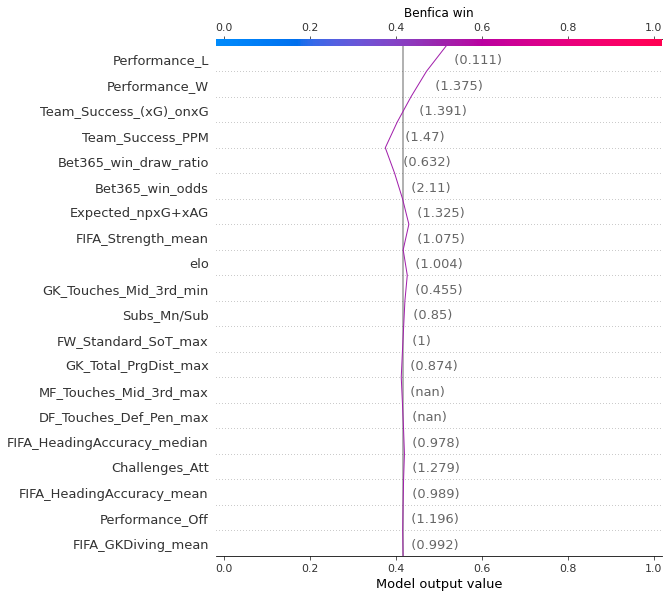

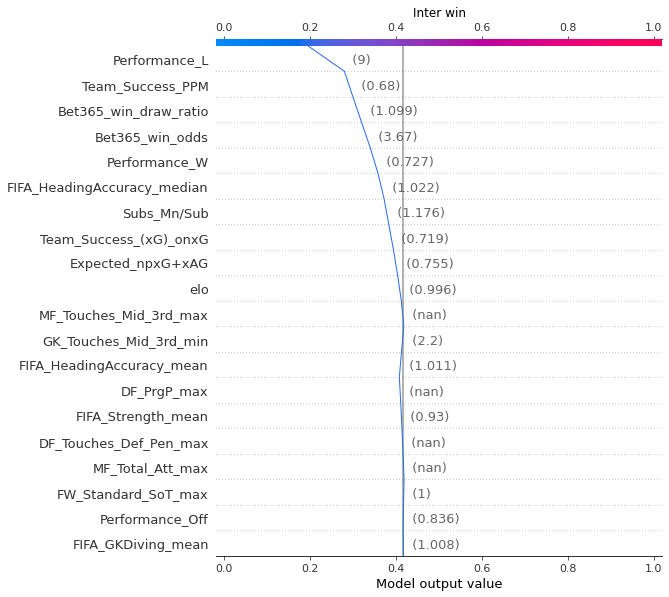

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


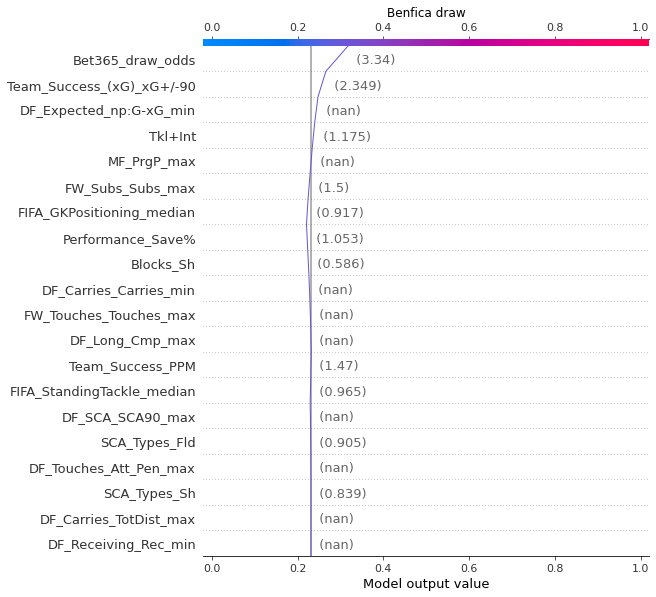

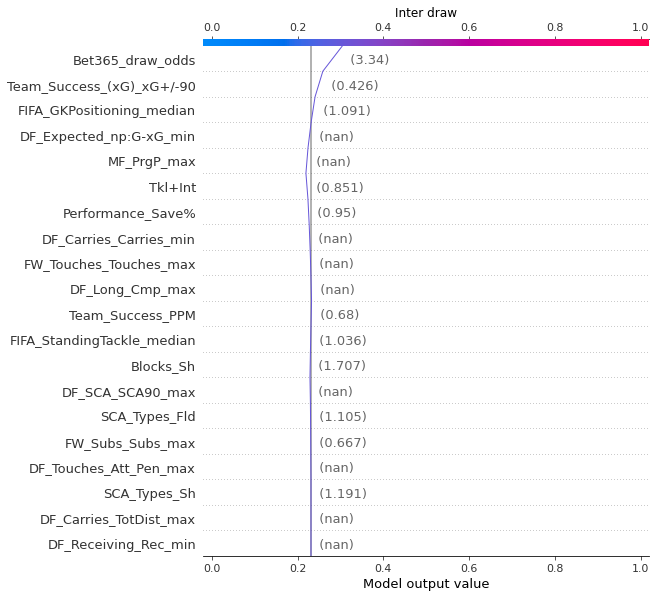

,match_id,Team,Match_date,Win_prob,Draw_prob
0,home_1,Benfica,2023-04-11,0.522943,0.370382
0,away_1,Inter,2023-04-11,0.198244,0.355849


In [224]:
model_prediction = make_prediction(
    home_team="Benfica",
    away_team="Inter",
    match_date="2023-04-11",
    bet365_home_win=2.11,
    bet365_away_win=3.67,
    bet365_draw=3.34,
)

model_prediction

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


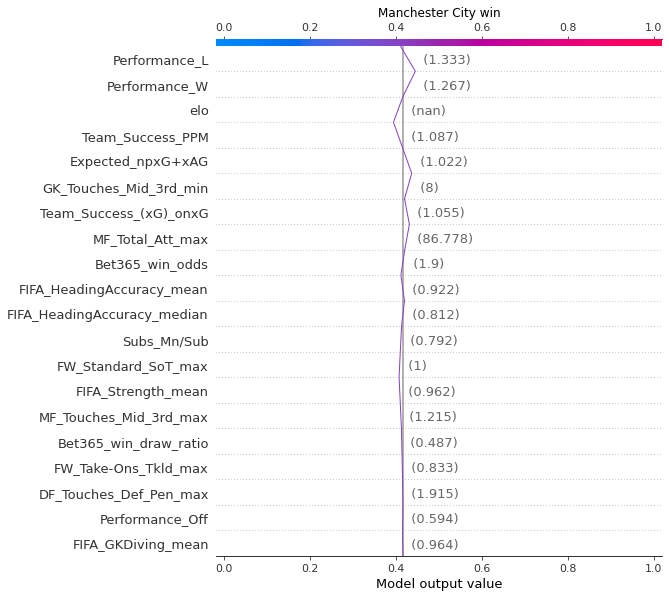

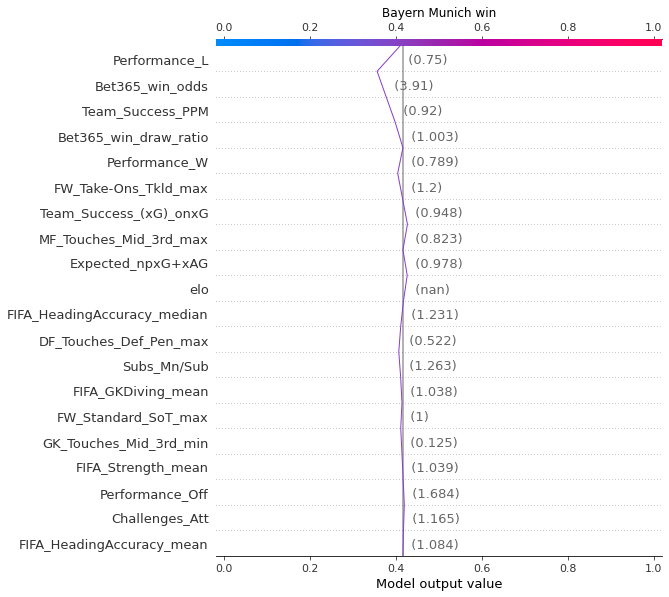

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


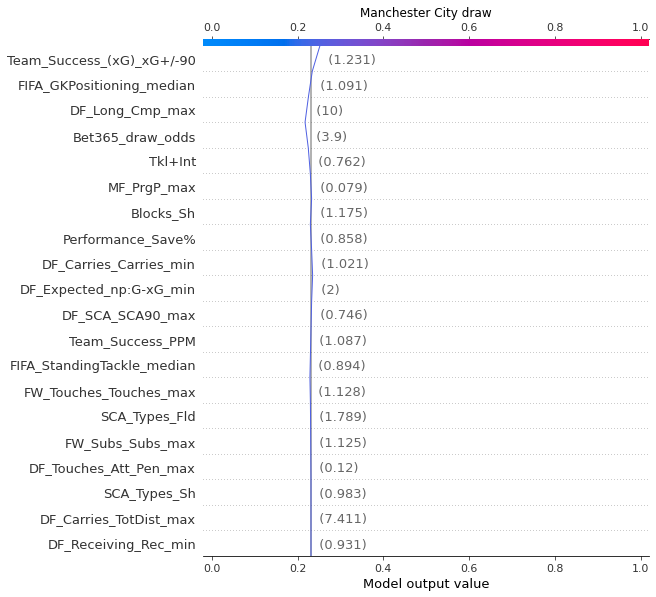

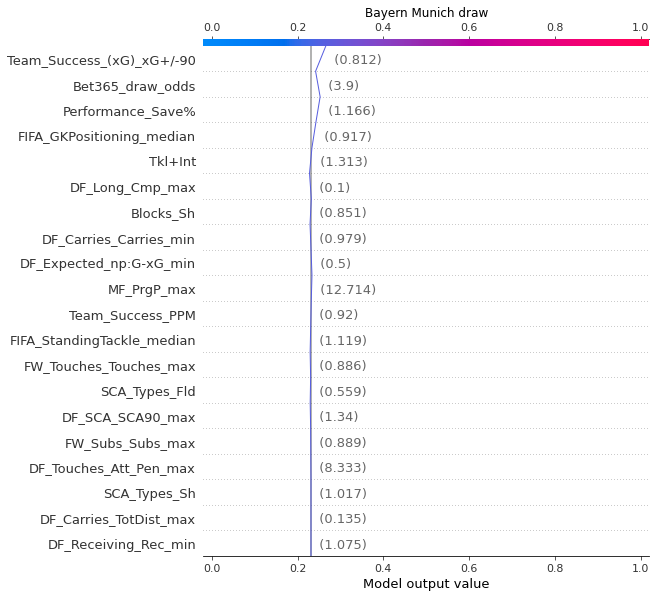

,match_id,Team,Match_date,Win_prob,Draw_prob
0,home_1,Manchester City,2023-04-11,0.415537,0.298239
0,away_1,Bayern Munich,2023-04-11,0.415381,0.313700


In [225]:
model_prediction = make_prediction(
    home_team="Manchester City",
    away_team="Bayern Munich",
    match_date="2023-04-11",
    bet365_home_win=1.90,
    bet365_away_win=3.91,
    bet365_draw=3.90,
)

model_prediction

### 2023-04-12
- **Real Madrid** - ['ESP-La Liga'] : **Chelsea** - ['ENG-Premier League']
- **Milan** - ['ITA-Serie A'] : **Napoli** - ['ITA-Serie A']

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


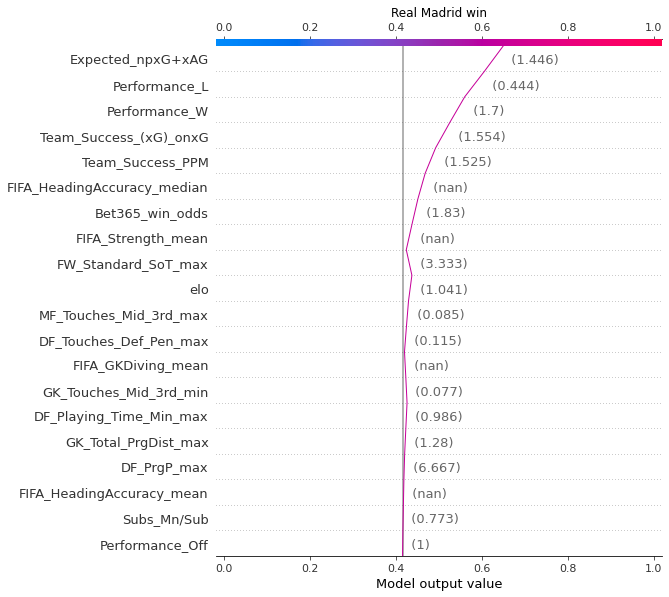

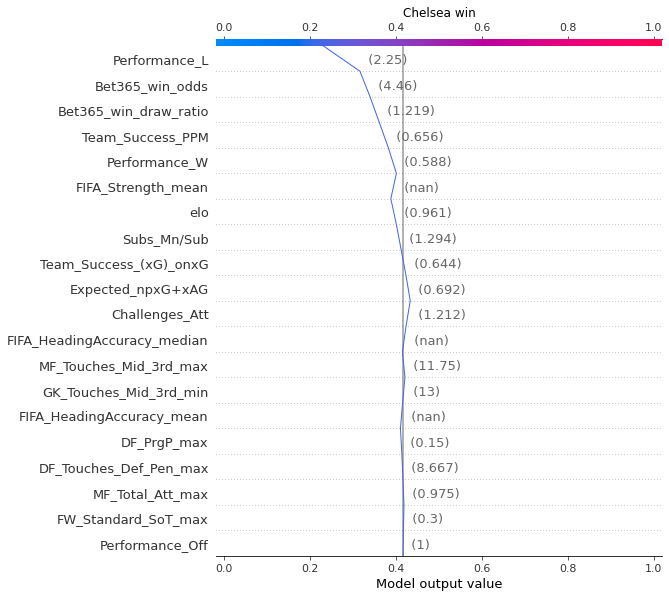

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


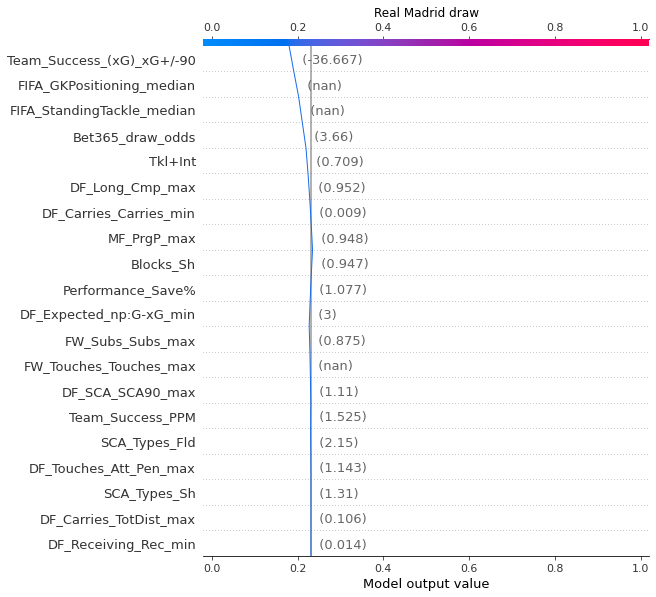

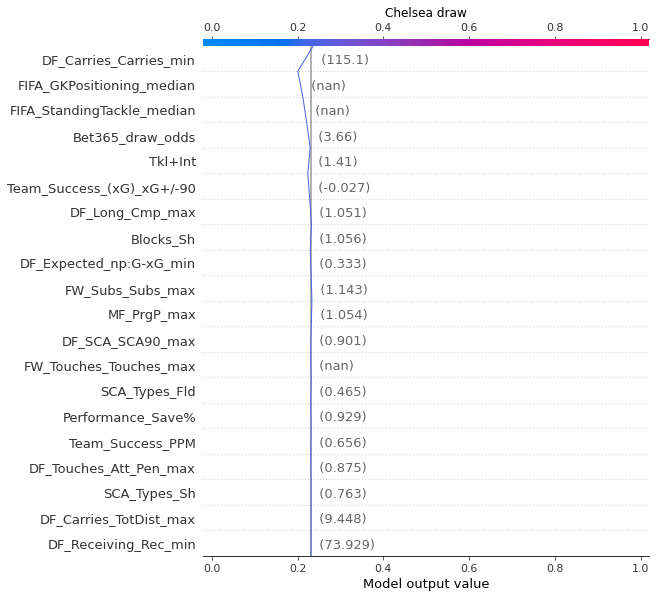

,match_id,Team,Match_date,Win_prob,Draw_prob
0,home_1,Real Madrid,2023-04-12,0.655331,0.217128
0,away_1,Chelsea,2023-04-12,0.234330,0.281281


In [226]:
model_prediction = make_prediction(
    home_team="Real Madrid",
    away_team="Chelsea",
    match_date="2023-04-12",
    bet365_home_win=1.83,
    bet365_away_win=4.46,
    bet365_draw=3.66,
)

model_prediction

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


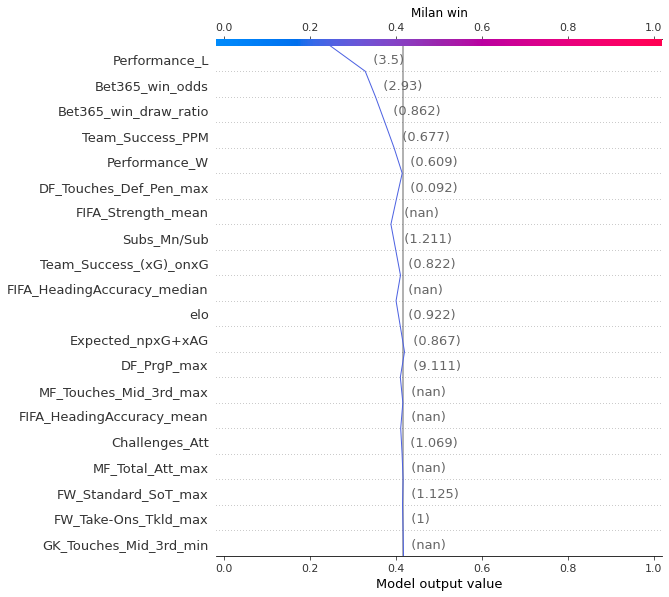

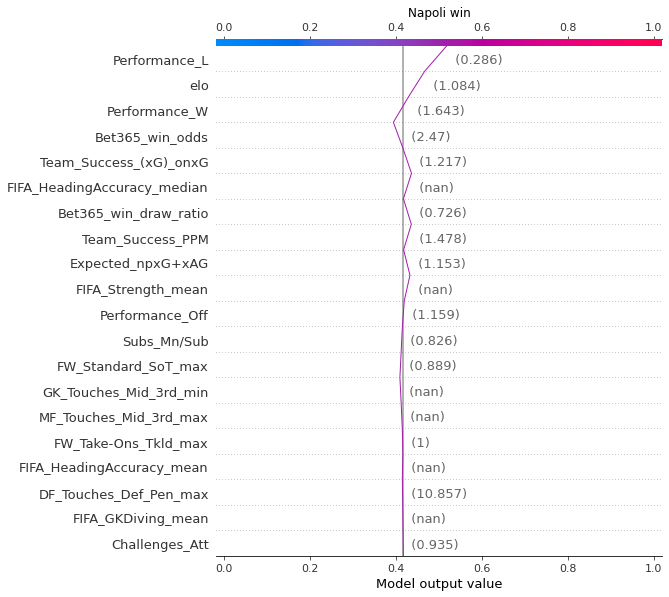

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


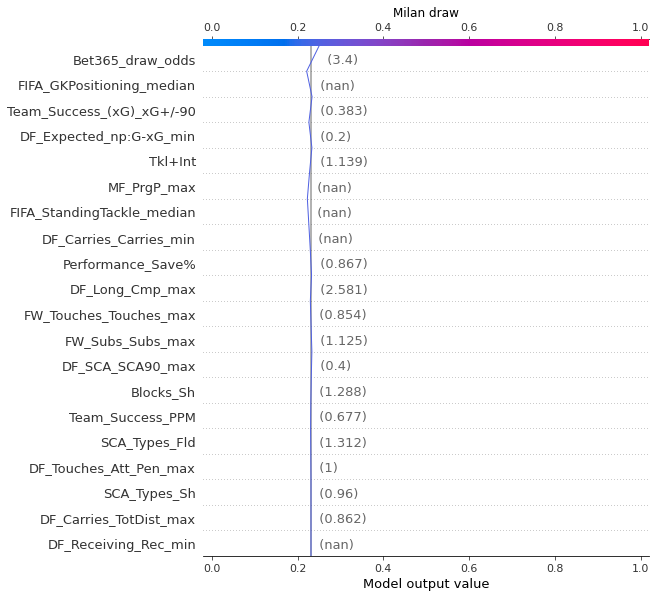

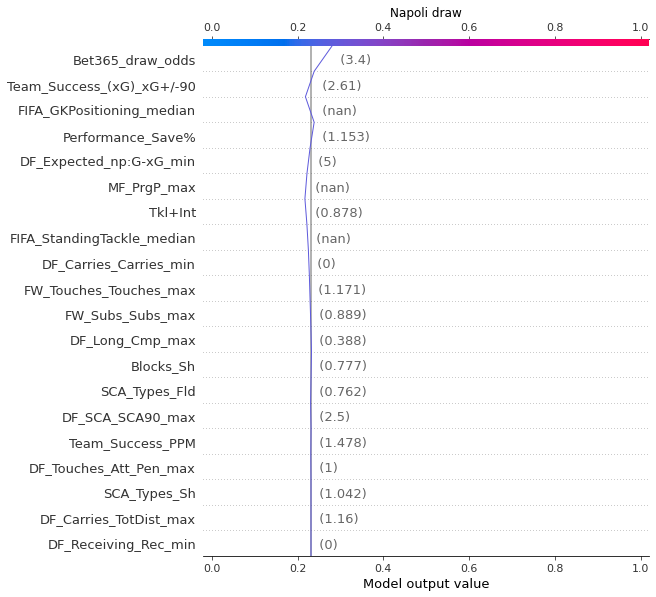

,match_id,Team,Match_date,Win_prob,Draw_prob
0,home_1,Milan,2023-04-12,0.250873,0.296294
0,away_1,Napoli,2023-04-12,0.524125,0.329728


In [227]:
model_prediction = make_prediction(
    home_team="Milan",
    away_team="Napoli",
    match_date="2023-04-12",
    bet365_home_win=2.93,
    bet365_away_win=2.47,
    bet365_draw=3.40,
)

model_prediction